In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [25]:
# stats
from scipy import stats
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
# evaluation
from sklearn.metrics import silhouette_score
# distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
# Principal Component Analysis
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score

In [26]:
df = pd.read_csv("../../our_analyses/dataset_prepared.csv")

df['explicit'] = df['explicit'].apply(lambda x: 1 if x else 0)
df['genre'] = pd.factorize(df['genre'])[0]
y = np.array(df["genre"])
df = df.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
X = df.values

scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

In [27]:
# get PCA
pca = PCA(n_components=3)
model = pca.fit(X_minmax)
# run PCA
X_pc = model.transform(X_minmax)

# get the number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_pca = pd.DataFrame(dic.items())
print(df_pca)

     0                 1
0  PC0              mode
1  PC1  instrumentalness
2  PC2      acousticness


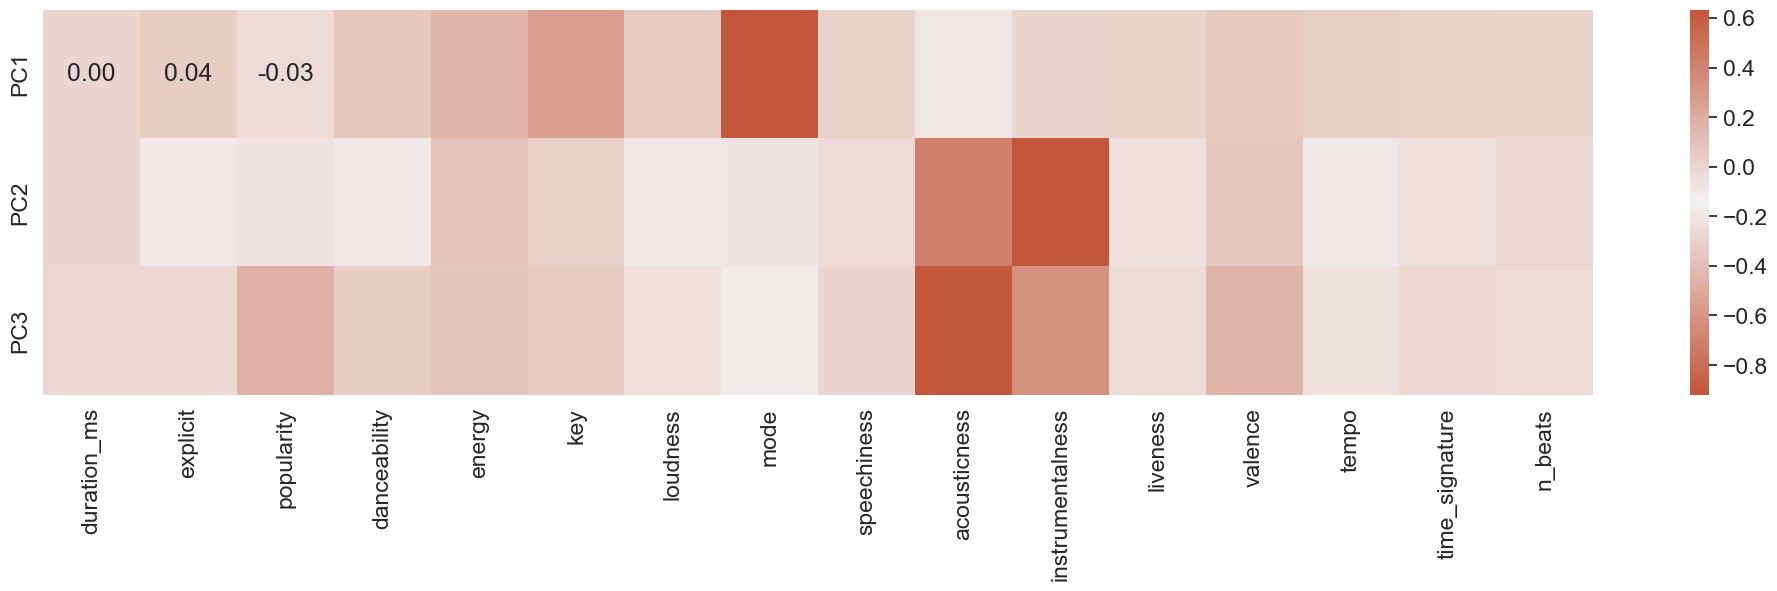

In [28]:
plt.figure(figsize=(25,5))
sns.set_theme(font_scale=1.5)
cmap = sns.diverging_palette(20, 20, as_cmap=True)
sns.heatmap(model.components_, annot=True, xticklabels=df.columns, yticklabels=["PC1", "PC2", "PC3"], fmt=".2f", cmap=cmap)
plt.savefig("PCA.svg", format="svg")

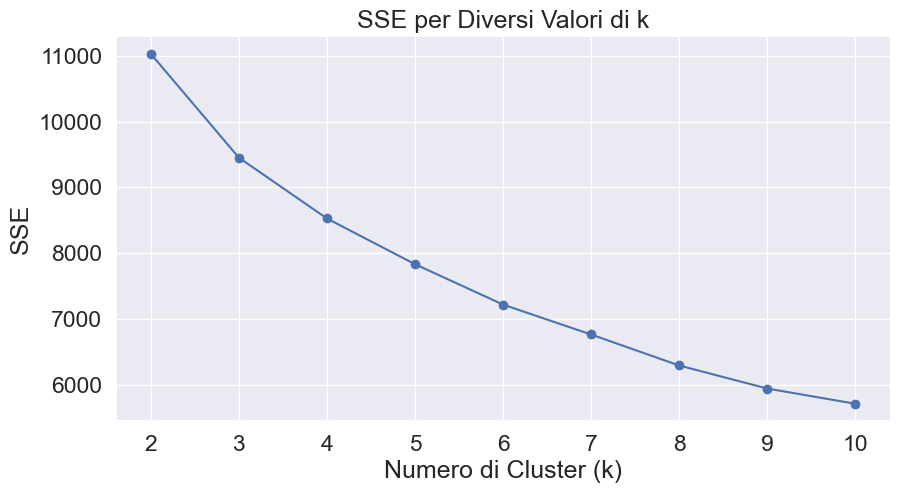

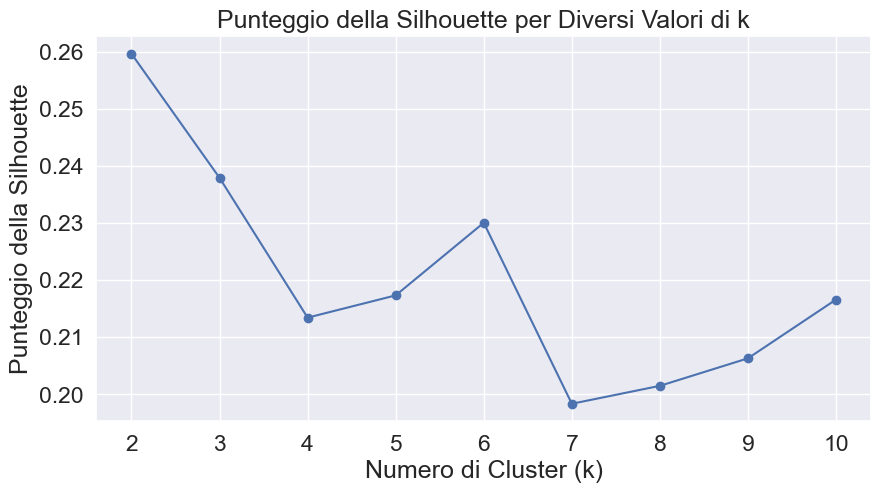

In [29]:
# Lista per memorizzare SSE e punteggi silhouette
sse_list = []
silhouette_scores = []

# Ciclo da k=2 a k=10 per calcolare SSE e punteggio silhouette
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_minmax, kmeans.labels_))

# Grafico per SSE
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), sse_list, marker='o')
plt.title('SSE per Diversi Valori di k')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('SSE')
plt.show()

# Grafico per il punteggio silhouette
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Punteggio della Silhouette per Diversi Valori di k')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('Punteggio della Silhouette')
plt.show()

In [30]:
# Lista per salvare i risultati di silhouette e SSE
silhouette_scores = []
sse_values = []

# Prova con un numero di cluster da 2 a 10
for num_clusters in range(2, 11):
    # Modello K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_minmax)
    
    # Calcolo silhouette score
    silhouette_avg = silhouette_score(X_minmax, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # Calcolo SSE
    sse = kmeans.inertia_
    sse_values.append(sse)

# Stampa i risultati
print("Numero di Cluster | Silhouette Score | SSE")
print("-----------------------------------------")
for num_clusters, silhouette, sse in zip(range(2, 11), silhouette_scores, sse_values):
    print(f"{num_clusters:^18} | {silhouette:^16.4f} | {sse:^8.2f}")

/Users/francescocapria/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/francescocapria/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/francescocapria/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/francescocapria/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

Numero di Cluster | Silhouette Score | SSE
-----------------------------------------
        2          |      0.2597      | 11032.08
        3          |      0.2394      | 9453.00 
        4          |      0.2134      | 8527.78 
        5          |      0.2173      | 7832.75 
        6          |      0.2300      | 7218.10 
        7          |      0.2153      | 6663.89 
        8          |      0.2017      | 6291.87 
        9          |      0.2063      | 5941.83 
        10         |      0.1926      | 5726.82 


In [31]:
kmeans = KMeans(n_clusters=6, n_init=10, max_iter=100, random_state=4)
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=6, n_init=10, random_state=4)

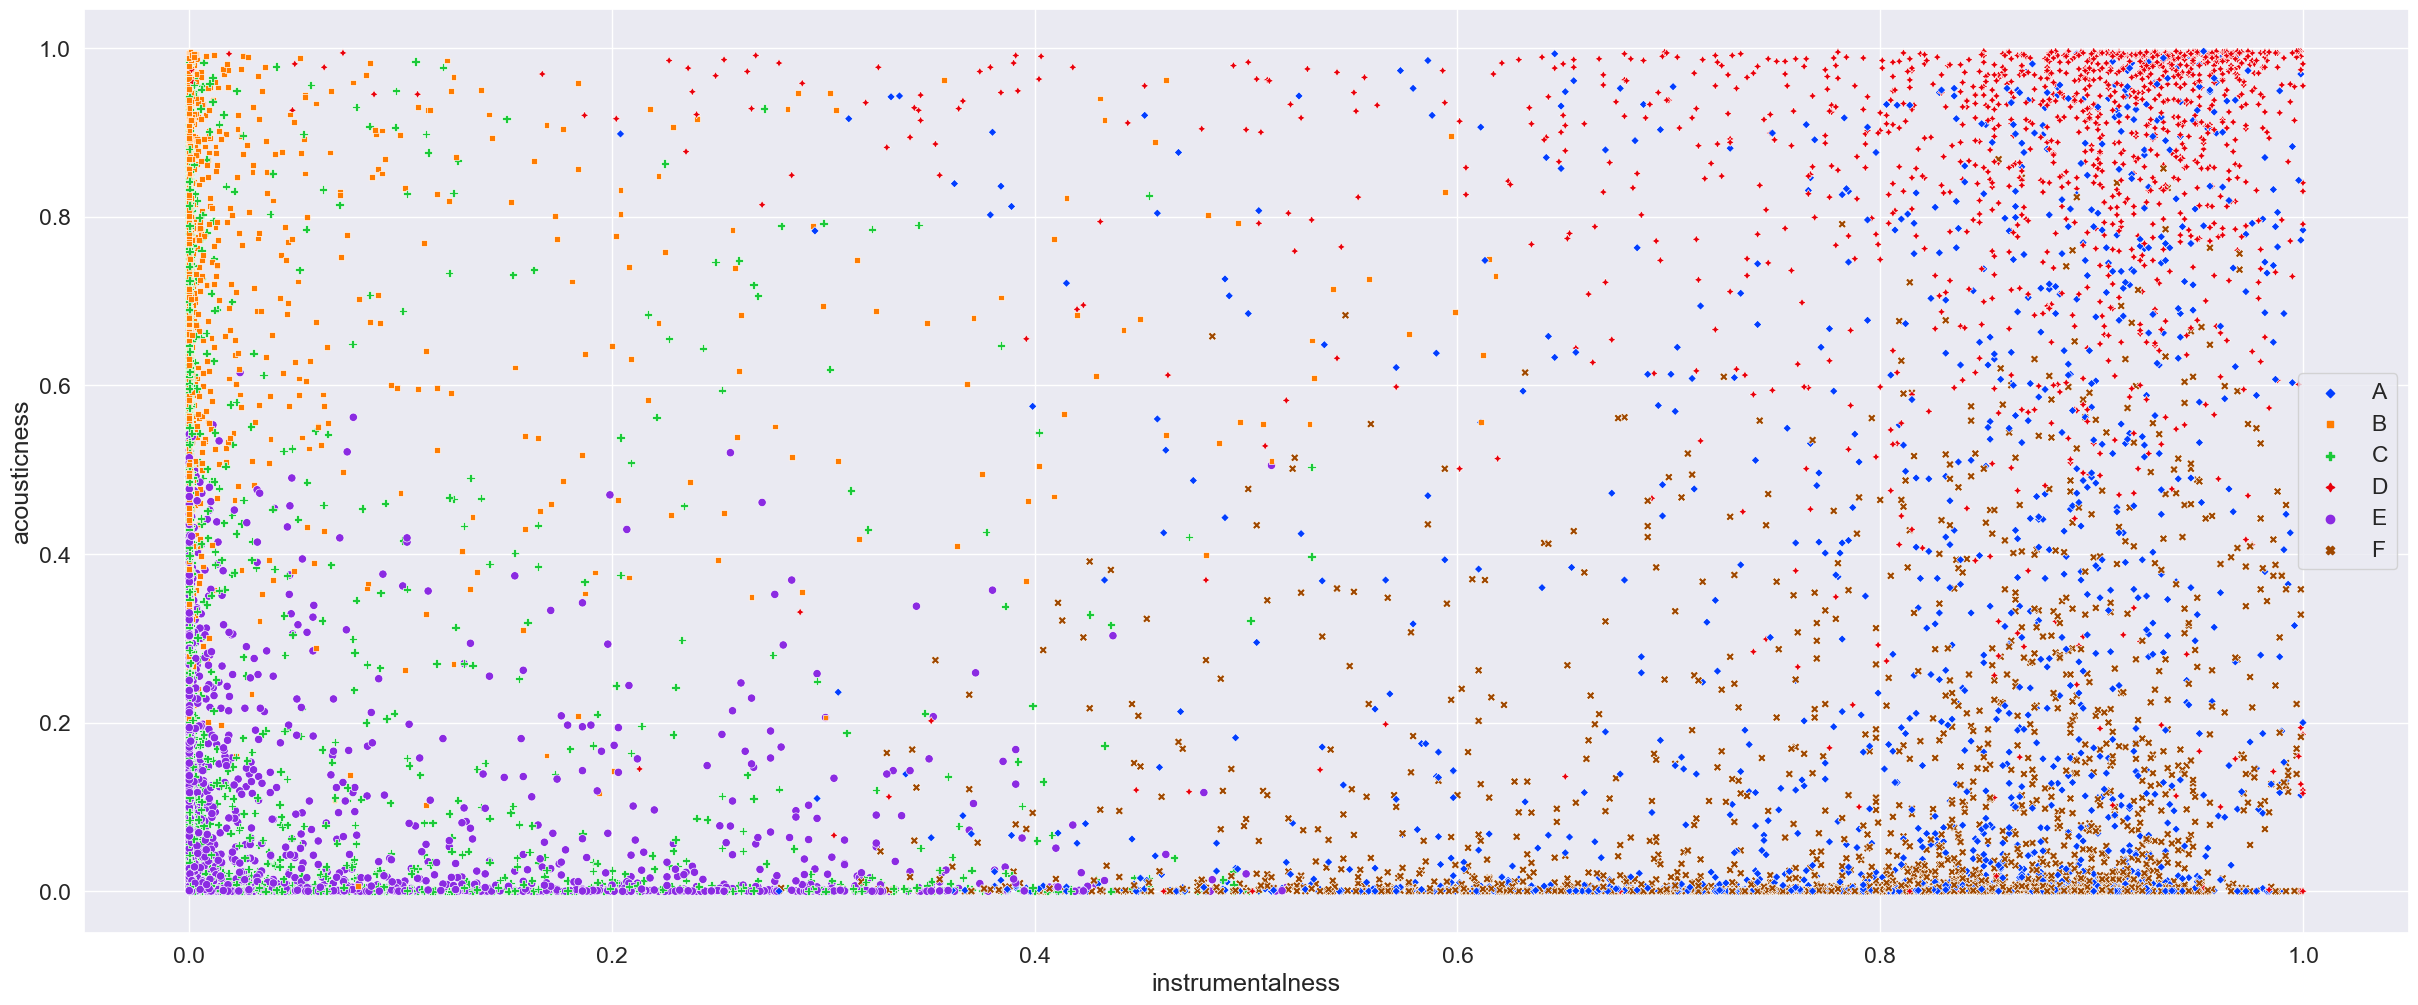

In [32]:
plt.figure(figsize=(30, 12))

centers = scaler.inverse_transform(kmeans.cluster_centers_)
df['kmeans_labels'] = kmeans.labels_
df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C", 3:"D", 4: "E", 5: "F"})

sns.scatterplot(data=df, 
                x="instrumentalness", 
                y="acousticness", 
                hue='kmeans_labels', 
                style='kmeans_labels',
                palette="bright", 
                hue_order=["A", "B", "C", "D", "E", "F"]
               )
plt.legend()
plt.show()

In [35]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
# Read sample 'simple3' from file.
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X_minmax, amount_initial_centers).initialize()
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X_minmax, initial_centers, 20)
xmeans_instance.process()
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
# Visualize clustering results

visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, X_minmax)
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show()

AttributeError: module 'numpy' has no attribute 'warnings'